#DATASET FULL SEM DA
##PRIMEIRO DIGITO DATASET 0 = FULL 1 = BALANCEADO
##SEGUNDO DIGITO DA 0 = NAO 1 = SIM
##ultimos dois numero de epocas = 50
##tamanho padrao do modelo 224
##lote 100

In [1]:
#importando drive com imagens
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [1]:
!pip show tensorflow


Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [2]:
!pip install --upgrade tensorflow


  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:00
Using cached ml_dtypes-0.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling

In [3]:
!pip show tensorflow


Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [4]:
!pip install --upgrade keras


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import seaborn as sns
import pathlib


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D # Updated import statements
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from keras import metrics

In [6]:
train_dir = pathlib.Path("/content/drive/MyDrive/DATASET/Dataset_full/ds_train")
test_dir = pathlib.Path("/content/drive/MyDrive/DATASET/Dataset_full/ds_test")
print(train_dir)
print(test_dir)

/content/drive/MyDrive/DATASET/Dataset_full/ds_train
/content/drive/MyDrive/DATASET/Dataset_full/ds_test


In [7]:
#tamanho de imagem
vgg16_img_size = 224
#número de exemplos que serão processados juntos em uma única iteração do modelo durante o treinamento
vgg16_batch_size = 100

# Dataset de treino
vgg16_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,  # Dividir 10% dos dados para validação
    subset="training",     # Definir que esta é a parte de treino
    seed=123,
    image_size=(vgg16_img_size, vgg16_img_size),
    batch_size=vgg16_batch_size)

# Dataset de validação
vgg16_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,  # Usar 10% dos dados para validação
    subset="validation",   # Definir que esta é a parte de validação
    seed=123,
    image_size=(vgg16_img_size, vgg16_img_size),
    batch_size=vgg16_batch_size)

# Dataset de teste
vgg16_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(vgg16_img_size, vgg16_img_size),
    batch_size=vgg16_batch_size)


classes_train = vgg16_train_ds.class_names
classes_val = vgg16_val_ds.class_names
class_names = vgg16_test_ds.class_names

print(f"Classes de teste: {class_names}, classes de validação: {classes_val}, classes de treino: {classes_train}")

Found 43028 files belonging to 5 classes.
Using 38726 files for training.
Found 43028 files belonging to 5 classes.
Using 4302 files for validation.
Found 4779 files belonging to 5 classes.
Classes de teste: ['basal_cell_carcinoma', 'melanoma', 'nevus', 'seborrheic_keratosis', 'squamous_cell_carcinoma'], classes de validação: ['basal_cell_carcinoma', 'melanoma', 'nevus', 'seborrheic_keratosis', 'squamous_cell_carcinoma'], classes de treino: ['basal_cell_carcinoma', 'melanoma', 'nevus', 'seborrheic_keratosis', 'squamous_cell_carcinoma']


In [8]:
for image_batch, labels_batch in vgg16_train_ds:
  vgg16_train_img = image_batch
  vgg16_train_labels = labels_batch
  break
for image_batch, labels_batch in vgg16_val_ds:
  vgg16_val_img = image_batch
  vgg16_val_labels = labels_batch
  break
for image_batch, labels_batch in vgg16_test_ds:
  vgg16_test_img = image_batch
  vgg16_test_labels = labels_batch
  break

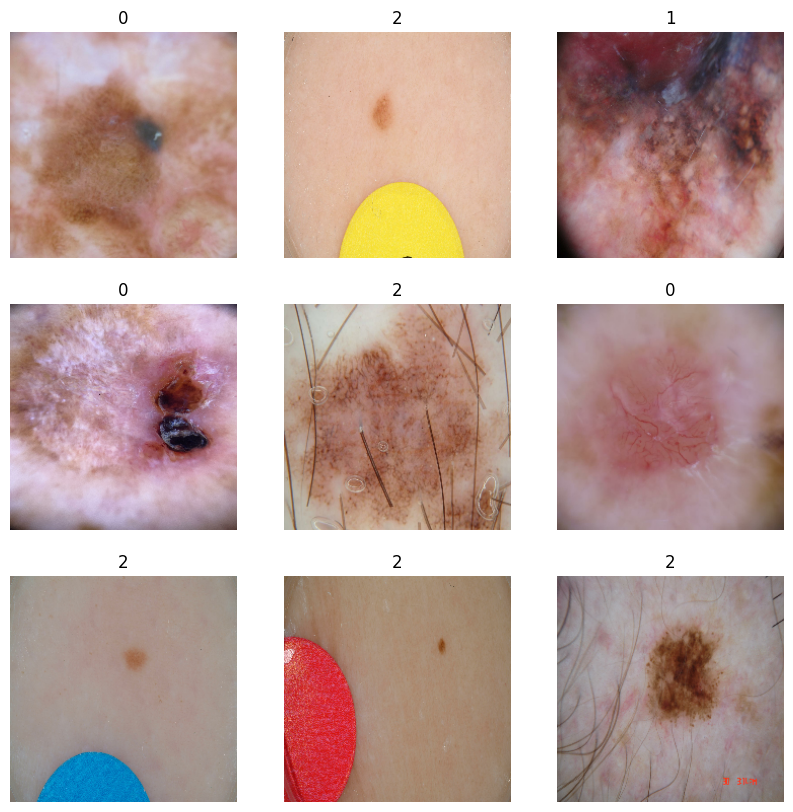

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(vgg16_train_img[i].numpy().astype("uint8"))
    plt.title(int(vgg16_train_labels[i]))
    plt.axis("off")

In [10]:
# ajusta automaticamente o número de threads para o pré-processamento dos dados. melhorar a performance e a eficiência do pipeline de dados.
AUTOTUNE = tf.data.experimental.AUTOTUNE

vgg16_train_ds = vgg16_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
vgg16_val_ds = vgg16_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
vgg16_test_ds = vgg16_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# VGG16
img_shape = (vgg16_img_size,vgg16_img_size,3)
VGG16_model = tf.keras.applications.VGG16(input_shape=img_shape,include_top=False,weights='imagenet')

In [12]:
VGG16_model.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5,activation='relu',bias_regularizer=regularizers.l2(1e-4))

In [13]:
from tensorflow.keras import layers, models, regularizers

num_classes = 5
vgg16_model = models.Sequential([
    VGG16_model,                         # Modelo base VGG16 congelado
    global_average_layer,                # Global Average Pooling para achatar a saída
    layers.BatchNormalization(),         # Normalização por batch após GlobalAveragePooling
    layers.Dense(256, activation='relu', # Camada densa intermediária com 256 neurônios
                 bias_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),                 # Dropout para evitar overfitting
    layers.Dense(num_classes, activation='softmax')  # Camada final para 5 classes
])

In [ ]:
#build?

In [14]:
vgg16_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
#vgg16_model.summary()
#nao da pra dar o summary versao do Tensorflow ta bugada, 2.15 funciona mas é mt relevante. ao fazer o downgrade o keras tmb volta pra 2.15

In [15]:
epochs = 50
history = vgg16_model.fit(
  vgg16_train_ds,
  validation_data=vgg16_val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


388/388 ━━━━━━━━━━━━━━━━━━━━ 3672s 1s/step - accuracy: 0.6827 - loss: 0.9364 - val_accuracy: 0.7534 - val_loss: 0.6460
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 98s 254ms/step - accuracy: 0.7625 - loss: 0.6399 - val_accuracy: 0.7680 - val_loss: 0.6129
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 99s 255ms/step - accuracy: 0.7719 - loss: 0.5992 - val_accuracy: 0.7643 - val_loss: 0.6085
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 99s 255ms/step - accuracy: 0.7856 - loss: 0.5651 - val_accuracy: 0.7731 - val_loss: 0.5995
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 99s 255ms/step - accuracy: 0.7934 - loss: 0.5485 - val_accuracy: 0.7780 - val_loss: 0.5898
Epoch 6/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 99s 255ms/step - accuracy: 0.8039 - loss: 0.5220 - val_accuracy: 0.7717 - val_loss: 0.5947
Epoch 7/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 99s 255ms/step - accuracy: 0.8107 - loss: 0.5026 - val_accuracy: 0.7787 - val_loss: 0.5944
Epoch 8/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 99s 255ms/step - accuracy: 0.8148 - loss: 0.4894 - val_

In [16]:
vgg16_loss, vgg16_acc = vgg16_model.evaluate(vgg16_test_ds)

48/48 ━━━━━━━━━━━━━━━━━━━━ 392s 8s/step - accuracy: 0.7467 - loss: 1.4130


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 940ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
4/4 ━━━━━━

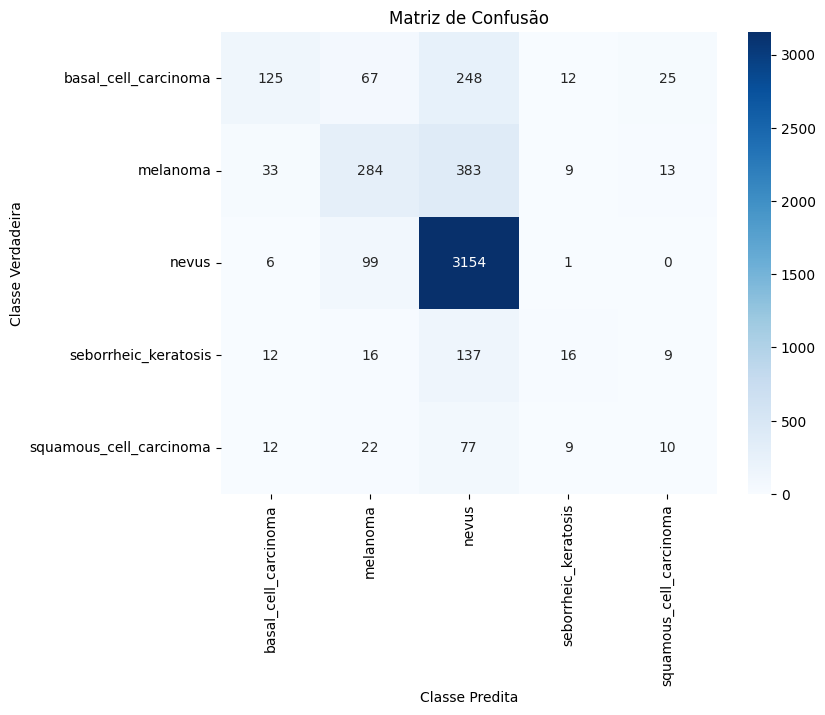

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = []  # Lista para armazenar previsões
y_true = []  # Lista para armazenar os rótulos verdadeiros

# Passar por todos os batches do conjunto de teste
for images, labels in vgg16_test_ds:
    # Gerar previsões
    preds = vgg16_model.predict(images)
    # Armazenar as previsões
    y_pred.extend(np.argmax(preds, axis=1))  # Armazenar o índice da classe predita
    y_true.extend(labels.numpy())  # Armazenar diretamente os índices das classes verdadeiras

# Converter para arrays numpy
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# 3. Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# 4. Imprimir o classification report
print("\nRelatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# 5. Visualizar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()